In [1]:
%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import getpass
# import os


# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")

In [5]:
from langchain.tools import tool
import subprocess

shell = subprocess.Popen("/bin/bash", shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)


@tool
def terminal(command: str) -> str:
    """Executes the given command in a terminal and returns the output.
    
    Parameters
    ----------
    command : str
        The command that gets executed in the terminal

    Returns
    -------
    str
        the return code of the terminal, 0 means successful execution
    """
    
    print(f"\nExecuting command: {command}")
    # Send command to the shell
    shell.stdin.write(command + "\n")
    shell.stdin.flush()

    # Wait for the command to finish and capture its output
    shell.stdin.write("echo $? > /tmp/last_exit_code\n")
    #shell.stdin.flush()
    shell.stdin.write("cat /tmp/last_exit_code\n")
    shell.stdin.flush()

    # Read command output until EOF (or next prompt)
    stdout_lines = []
    stderr_lines = []
    while True:
        line = shell.stdout.readline()
        stdout_lines.append(line)
        
        # print(shell.stdout,shell.stderr)
        if line.startswith("0") or line.startswith("1") or line== (''):
            break

        
    print("".join(stdout_lines))

    return "".join(stdout_lines)

tools = [terminal]

In [ ]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

from langgraph.prebuilt import create_react_agent

# # # Get the prompt to use - you can modify this!
# prompt = hub.pull("ih/ih-react-agent-executor")
# prompt.pretty_print()

prompt = ChatPromptTemplate([("system", "You are an AI Assistant executing terminal commands based on given instructions. After each execution you report the success or result."), ("placeholder", "{conversation}")])
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o", temperature=0)
agent_executor = create_react_agent(llm, tools)

================================ System Message ================================

You are an AI Assistant executing terminal commands based on given instructions. After each execution you report the success or result.

============================= Messages Placeholder =============================

{conversation}


In [7]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

"""
First, we will need to track the current plan. Let's represent that as a list of strings.
Next, we should track previously executed steps. Let's represent that as a list of tuples (these tuples will contain the step and then the result)
Finally, we need to have some state to represent the final response as well as the original input.
"""
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [8]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [9]:
from langchain_core.prompts import ChatPromptTemplate

# """For the given objective, come up with a simple step by step plan. \
# This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
# The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps."""


planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given task, create a simple, step-by-step execution plan for an AI agent executing terminal commands. \
                Each step should correspond to a specific command or action derived from the task that can be solved within the terminal. Ensure that each step is self-contained, \
                with all necessary details provided for successful execution. Avoid adding unnecessary steps or overly verbose descriptions. Opening or closing the terminal should not be part of this list.\
                The result of the final step should fulfill the objective outlined in the prompt. Ensure clarity and correctness to prevent missteps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

In [10]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given tutorial or guide, update the step-by-step execution plan based on progress made so far. \
Each step should represent a specific command or action still required to complete the objective. Ensure that each step is self-contained, \
clear, and provides all necessary details for successful execution. Avoid repeating already completed steps or adding unnecessary ones.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently completed the following steps:
{past_steps}

Update the plan accordingly. If no further steps are needed and the objective is complete, indicate that. Otherwise, provide the remaining steps that still NEED to be done."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

In [16]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan: {plan_str}\n\nYou are tasked with executing step {1}, {task}\n \n Report the status of the execution."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )

    print(f"Agent response: {agent_response['messages']} \n")

    # for chunk in agent_response['messages']:
    #     print(chunk)


    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    print(f"Replanner: {output}")
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [17]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

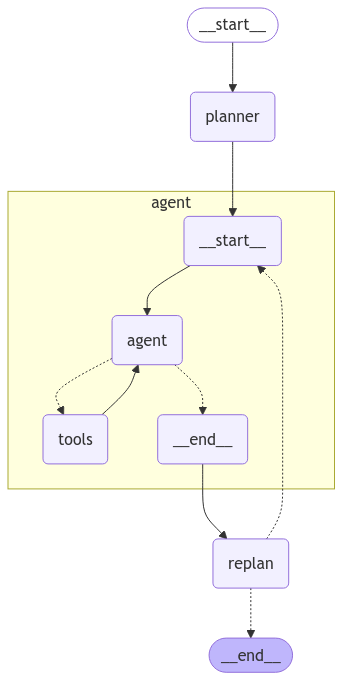

In [18]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [19]:
config = {"recursion_limit": 50}
inputs = {"input": "Check to have python 3.12"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)
            

{'plan': ["Run the command 'python3.12 --version' to check if Python 3.12 is installed and to display its version number if it is."]}

Executing command: python3.12 --version
Agent response: [HumanMessage(content="For the following plan: 1. Run the command 'python3.12 --version' to check if Python 3.12 is installed and to display its version number if it is.\n\nYou are tasked with executing step 1, Run the command 'python3.12 --version' to check if Python 3.12 is installed and to display its version number if it is.\n \n Report the status of the execution.", additional_kwargs={}, response_metadata={}, id='65a40a1d-2d79-4b8a-9937-d2ae65f5e5cf'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uSSke7Vu9zqejoaBdyeS4Hwk', 'function': {'arguments': '{"command":"python3.12 --version"}', 'name': 'terminal'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 176, 'total_tokens': 195, 'completion_tokens_deta

CancelledError: 